This Notebook is companion code for Chapter 5 of the material entitled "Deep Learning Models: A Practical Approach for Hands-On Professionals" which gives details of evaluation evaluation results. It has be successfully executed in Google Colab. We first made a comparison of the performance of various classes of Keras models using the publicly available EuroSat dataset (https://github.com/phelber/EuroSAT ) as input. Specifically, we will evaluate ResNet, VGG, NasNet and EfficientNet V1 models to see how they compare under similar conditions except where model specific treatment is necessary.
From this comaprison we obtained the best performing model weights from VGG16 model. 

**ABOUT GWERU DATASET**

We applied then applied the above best model to separately acquired data. This dataset is also Sentiel-2 acquired data which covers the areas surrounding Gweru city of Zimbabwe. Gweru is a small city that is characterized by a dry, cool winter season from May to July, a hot, dry period in August to early November, and a warm, rainy period from early November to April. The hottest month is October, while the coldest is July. The temperatures range from an average of 21 °C in July to 30 °C in October, while the annual rainfall is about 684 mm. In this chapter, only median post rainy-season Sentinel-2 imagery will be used for land cover classification. Although the median post-rainy Sentinel-2 imagery (April - June 2020) comprises 13 spectral bands with a spatial resolution that range between 10 m and 20 m, we will only use RGB bands in a similar fashion to the EuroSat dataset. It has been already proven in [3] that RGB bands give the highest accuracy when deep learning algorithms considered. As preparation the original GeoTiff format data is converted into 64x64 patches for processing by the deep learning algorithm. Since we have already confirmed that the VGG16 the best performing model on the EuroSat dataset, we evaluated only this model on the Gweru dataset.
Evaluation results on the 10-class dataset were far from satisfactory so we resorted to retraining the model with the limited dataset and merged classes to 5 & 6 classes respectivley.

**The Gweru Dataset can be provided upon request an is necessary to run this script.**

In [ ]:
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


We show the following results:

(1) Explore the 6-class dataset (as an example)

(2) Evaluation of 10-classes with EuroSat weights (10 classes)

(3) Training results with 6 classes

(4) Training results with 5 classes 

# Exploration of 6-Class Dataset

In this section, we will explore the zimsat Gweru dataset. The zimsat dataset is composed of images taken from the Sentinel-2 satellite. This dataset consists of 3 datasets that are devided according to the number of class labels. The first dataset is split into 10 classes, the second into 6 classes and final the third is 5 classes. We show the following results:

(1) Explore the 6-class dataset (as an example)

(2) Evaluation of 10-classes with EuroSat weights (10 classes)

(3) Training results with 6 classes

(4) Training results with 5 classes 

Set the path for 6-class Gweru dataset.

In [ ]:
#DATASET = "/content/drive/My Drive/Colab Notebooks/zimsat/testing_jpg_correctfmt" #10-classes ['AnnualCrop', 'Pasture', 'PermanentCrop', 'Residential', 'Industrial', 'River', 'SeaLake', 'HerbaceousVegetation', 'Highway', 'Forest']
DATASET = "/content/drive/My Drive/Colab Notebooks/zimsat/testing_jpg_merged1" # 6-classes ['BareAreas', 'Grassland', 'BuiltUp', 'Cropland', 'Water', 'Woodland']
#DATASET = "/content/drive/My Drive/Colab Notebooks/zimsat/testing_jpg_merged1_red1" # 5-classes {'BuiltUp': 0, 'Cropland': 1, 'GrassBareAreas': 2, 'Water': 3, 'Woodland': 4}
LABELS = os.listdir(DATASET)
print(LABELS)

['BareAreas', 'Grassland', 'BuiltUp', 'Cropland', 'Water', 'Woodland']


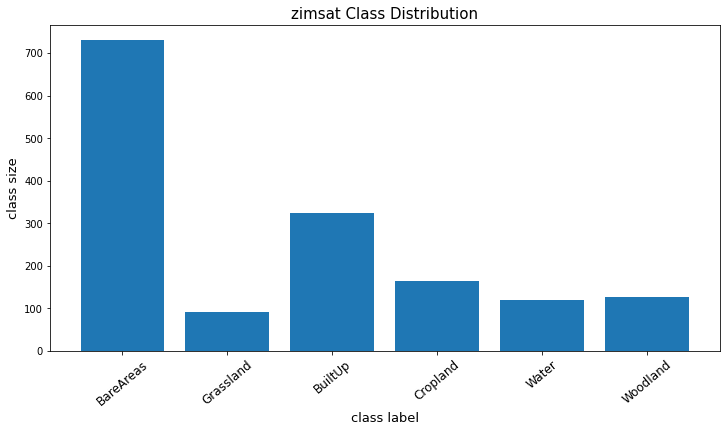

In [ ]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('zimsat Class Distribution', fontsize=15);

The dataset is split into 6 classes of land cover. Since each class varies in size, stratification will be used when when splitting the data into training, testing and validation sets.

In [ ]:
#img_paths = [os.path.join(DATASET, l, l+'_10.jpg') for l in LABELS]
#img_paths = img_paths + [os.path.join(DATASET, l, l+'_20.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

# plot_sat_imgs(img_paths)

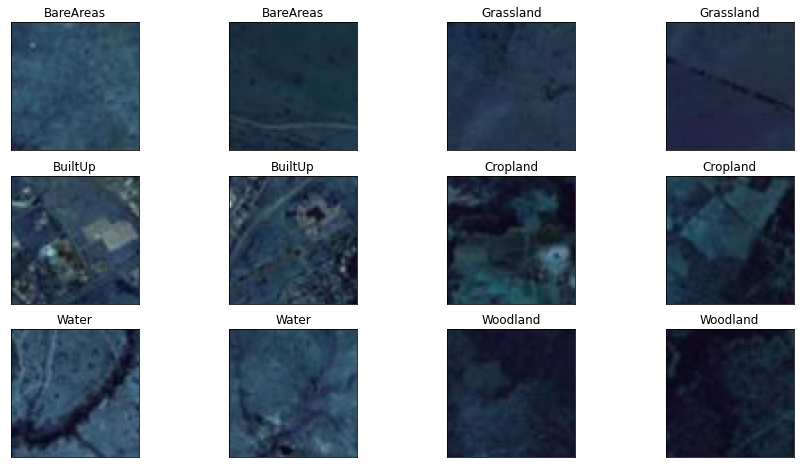

In [ ]:
# Preview of sample images
img_paths = []
for l in LABELS:
  img_pl = os.path.join(DATASET, l)
  file_pl = os.listdir(img_pl)
  for i in range(2):
   img_paths = img_paths + [os.path.join(DATASET, l,file_pl[i])]

def plot_sat_imgs2(paths):
    plt.figure(figsize=(15, 8))
    for i in range(12):
        plt.subplot(3, 4, i+1, xticks=[], yticks=[])
        #plt.subplot(2, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs2(img_paths)


The sample data shows the variability in contents of the classes from BareAreas to Woodland. Some similarities can be observed, for example, between Grassland and Woodland classes.The classes are less distinct compared to EuroSat data and this is generally the case for most datasets. The challenge for the deep learning algorithms is to be able to distinguish these classes by minimizing false positives and false negatives among other metrics that can be used. Although NIR band data is also available, our evaluation will solely use RGB bands.

# Preprocessing and Path Setting

Next the data is split into training and test sets using stratified shuffle-split from Scikit-learn. 
We also make use Keras ImageDataGenerator for data augmentation. 

In [ ]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/content/drive/My Drive/Colab Notebooks/zimsat/working/training'
TEST_DIR = '/content/drive/My Drive/Colab Notebooks/zimsat/working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [ ]:
# EXECUTE ONCE!!!!! map each image path to their class label in 'data'
"""
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    s_in ='/content/drive/My Drive/Colab Notebooks/zimsat/testing_jpg_merged1_red1'
    s_train ='/content/drive/My Drive/Colab Notebooks/zimsat/working/training'
    s_test = '/content/drive/My Drive/Colab Notebooks/zimsat/working/testing'
    new_train_paths = [re.sub(s_in, s_train, i) for i in train_paths]
    new_test_paths = [re.sub(s_in, s_test, i) for i in test_paths]
    #new_train_paths = [re.sub('\.\.\/input\/zimsat', '../working/training', i) for i in train_paths]
    #new_test_paths = [re.sub('\.\.\/input\/zimsat', '../working/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
              shutil.copy(i[0], i[1])   
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


100%|██████████| 781/781 [02:15<00:00,  5.76it/s]


moving testing files..


100%|██████████| 196/196 [00:31<00:00,  6.15it/s]


In [ ]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 780 images belonging to 5 classes.
Found 196 images belonging to 5 classes.


In [ ]:
print(train_generator.class_indices)

{'BuiltUp': 0, 'Cropland': 1, 'GrassBareAreas': 2, 'Water': 3, 'Woodland': 4}


In [ ]:
np.save('class_indices', train_generator.class_indices)

We then define the generic function for model selection and compilation using the following function.

In [ ]:
# Current: Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2') or (cnn_base == 'ResNet101') or (cnn_base == 'ResNet152'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet101':
            conv_base = ResNet101(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet152':
            conv_base = ResNet152(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(1024, activity_regularizer=regularizers.l2(1e-4), activation='relu')(top_model)
        top_model = Dense(1024, activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(1024, activity_regularizer=regularizers.l2(1e-4), activation='relu')(top_model)
        top_model = Dense(1024, activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model)
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(1024, activity_regularizer=regularizers.l2(1e-4), activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(1024, activity_regularizer=regularizers.l2(1e-4), activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model) 
        #top_model = Dense(1024, activity_regularizer=regularizers.l2(1e-4), activation='relu')(top_model) # add layers
        #top_model = BatchNormalization()(top_model) #added
        #top_model = Dropout(0.2)(top_model)
    elif (cnn_base == 'Xception') or (cnn_base == 'InceptionV3'):
        if cnn_base == 'Xception':
            conv_base = Xception(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = InceptionV3(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = GlobalAveragePooling2D()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model) 
    elif (cnn_base == 'NASNetLarge') or (cnn_base == 'NASNetMobile'):
        if cnn_base == 'NASNetLarge':
            conv_base = NASNetLarge(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)   
        else:
            conv_base = NASNetMobile(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = GlobalAveragePooling2D()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model) 
    elif (cnn_base == 'EfficientNetB0') or (cnn_base == 'EfficientNetB1') or (cnn_base == 'EfficientNetB2') or (cnn_base == 'EfficientNetB3') or (cnn_base == 'EfficientNetB4') or (cnn_base == 'EfficientNetB5') or (cnn_base == 'EfficientNetB6') or (cnn_base == 'EfficientNetB7'):
        if cnn_base == 'EfficientNetB0':
          conv_base = EfficientNetB0(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        elif cnn_base == 'EfficientNetB1':
          conv_base = EfficientNetB1(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        elif cnn_base == 'EfficientNetB2':
          conv_base = EfficientNetB2(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        elif cnn_base == 'EfficientNetB3':
          conv_base = EfficientNetB3(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        elif cnn_base == 'EfficientNetB4':
          conv_base = EfficientNetB4(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        elif cnn_base == 'EfficientNetB5':
          conv_base = EfficientNetB5(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        elif cnn_base == 'EfficientNetB6':
          conv_base = EfficientNetB6(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        else:
          conv_base = EfficientNetB7(include_top=False,
                                     weights="imagenet",
                                     input_shape=input_shape)
        top_model = conv_base.output
        top_model = GlobalAveragePooling2D()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = BatchNormalization()(top_model) #added
        top_model = Dropout(0.2)(top_model) 

    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model


In [ ]:
def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history['auc']
    val_auc = history.history['val_auc']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 3, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1, 3, 3)
    plt.plot(auc)
    plt.ylabel('auc')
    plt.plot(val_auc)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    #auc = roc_auc_score(y_true, y_preds, multi_class='ovr')
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}") 
    #print(f'AUC: {auc}')   
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

# Load necessary libaries

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam 
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications import ResNet50V2, ResNet50V2, ResNet152V2
#from keras.applications import InceptionV3, Xception
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score, roc_curve, roc_auc_score, auc
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB4, EfficientNetB5
from tensorflow.keras.applications import EfficientNetB6, EfficientNetB7
from tensorflow.keras.regularizers import l2,l1, l1_l2
from tensorflow.python.keras import regularizers

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5'

Configure GPUs for processing if available. It recommended to use the first available GPU for Tensorflow processing (https://www.tensorflow.org/guide/gpu#using_multiple_gpus).

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


# VGG16 Model Evaluation

# VGG16 MODEL -Evaluation of 10-classes with EuroSat weights

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

In [ ]:
# re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

In [ ]:
plot_history(vgg16_history)

In [ ]:
TEST_DIR_GWR = '/content/drive/My Drive/Colab Notebooks/zimsat/testing_jpg_merged1'

In [ ]:
# Check Data


In [ ]:
TDATASET = TEST_DIR_GWR
TLABELS = os.listdir(TDATASET)
print(TLABELS)

['Cropland', 'BareAreas', 'Grassland', 'BuiltUp', 'Water', 'Woodland']


In [ ]:
# plot class distributions of test dataset
counts = {}

for l in TLABELS:
    counts[l] = len(os.listdir(os.path.join(TDATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('Gweru Class Distribution', fontsize=15);

In [ ]:
counts

{'BareAreas': 730,
 'BuiltUp': 324,
 'Cropland': 164,
 'Grassland': 91,
 'Water': 120,
 'Woodland': 127}

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)
"""
#test_generator.reset()
test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR_GWR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 1648 images belonging to 10 classes.
Accuracy: 0.20449029126213591
Global F2 Score: 0.20449029126213591


,Precision,Recall,F-Score,Support
AnnualCrop,0.204545,0.146341,0.170616,123.0
Forest,0.000000,0.000000,0.000000,131.0
HerbaceousVegetation,0.422535,0.115533,0.181452,779.0
Highway,0.031250,0.062500,0.041667,32.0
Industrial,0.106383,0.138889,0.120482,36.0
Pasture,0.000000,0.000000,0.000000,98.0
PermanentCrop,0.333333,0.016667,0.031746,60.0
Residential,0.238987,0.821970,0.370307,264.0
River,0.057692,0.025641,0.035503,117.0
SeaLake,0.003831,0.125000,0.007435,8.0


In [ ]:
prf

In [ ]:
# confusion matrix as values
conf_mat

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,18,0,8,3,3,4,2,31,7,47
Forest,11,0,75,5,0,0,0,29,4,7
HerbaceousVegetation,35,1,90,32,21,3,0,444,22,131
Highway,1,0,1,2,0,0,0,24,2,2
Industrial,0,0,1,1,5,0,0,29,0,0
Pasture,10,1,22,7,0,0,0,34,5,19
PermanentCrop,5,0,1,5,7,0,1,23,3,15
Residential,4,0,5,5,4,3,0,217,5,21
River,3,0,10,3,6,0,0,74,3,18
SeaLake,1,0,0,1,1,0,0,3,1,1


In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,20.45,0.0,3.76,4.69,6.38,40.0,66.67,3.41,13.46,18.01
Forest,12.50,0.0,35.21,7.81,0.00,0.0,0.00,3.19,7.69,2.68
HerbaceousVegetation,39.77,50.0,42.25,50.00,44.68,30.0,0.00,48.90,42.31,50.19
Highway,1.14,0.0,0.47,3.12,0.00,0.0,0.00,2.64,3.85,0.77
Industrial,0.00,0.0,0.47,1.56,10.64,0.0,0.00,3.19,0.00,0.00
Pasture,11.36,50.0,10.33,10.94,0.00,0.0,0.00,3.74,9.62,7.28
PermanentCrop,5.68,0.0,0.47,7.81,14.89,0.0,33.33,2.53,5.77,5.75
Residential,4.55,0.0,2.35,7.81,8.51,30.0,0.00,23.90,9.62,8.05
River,3.41,0.0,4.69,4.69,12.77,0.0,0.00,8.15,5.77,6.90
SeaLake,1.14,0.0,0.00,1.56,2.13,0.0,0.00,0.33,1.92,0.38


In [ ]:
# Save the model and the weights
#vgg16_model.save('/content/drive/My Drive/Colab Notebooks/zimsat/working/vgg16_zimsat8breg_act_batch64.h5')

# VGG16 MODEL - Training results with 6 classes – unbalanced case

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 5.1365 - categorical_accuracy: 0.3729
Epoch 00001: val_categorical_accuracy improved from -inf to 0.25391, saving model to /content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5
19/19 [==============================] - 6s 257ms/step - loss: 5.1365 - categorical_accuracy: 0.3729 - val_loss: 25.1197 - val_categorical_accuracy: 0.2539
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 2.4777 - categorical_accuracy: 0.5136
Epoch 00002: val_categorical_accuracy improved from 0.25391 to 0.58984, saving model to /content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5
19/19 [==============================] - 4s 227ms/step - loss: 2.4777 - categorical_accuracy: 0.5136 - val_loss: 2.0725 - val_categorical_accuracy: 0.5898
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 1.6198 - categorical_accuracy: 0.5331
Epoch 00003: val_categorical_accuracy di

In [ ]:
# re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
19/19 [==============================] - ETA: 0s - loss: 1.3418 - categorical_accuracy: 0.5424
Epoch 00001: val_categorical_accuracy did not improve from 0.73828
19/19 [==============================] - 6s 225ms/step - loss: 1.3418 - categorical_accuracy: 0.5424 - val_loss: 6.2512 - val_categorical_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 2/200
19/19 [==============================] - ETA: 0s - loss: 1.2209 - categorical_accuracy: 0.5661
Epoch 00002: val_categorical_accuracy did not improve from 0.73828
19/19 [==============================] - 4s 204ms/step - loss: 1.2209 - categorical_accuracy: 0.5661 - val_loss: 1.3466 - val_categorical_accuracy: 0.5508 - lr: 1.0000e-04
Epoch 3/200
19/19 [==============================] - ETA: 0s - loss: 1.1332 - categorical_accuracy: 0.6059
Epoch 00003: val_categorical_accuracy did not improve from 0.73828
19/19 [==============================] - 4s 194ms/step - loss: 1.1332 - categorical_accuracy: 0.6059 - val_loss: 0.8697 - val_categori

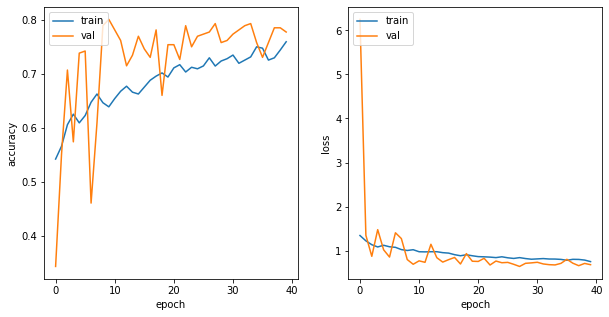

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 312 images belonging to 6 classes.
Accuracy: 0.6474358974358975
Global F2 Score: 0.6474358974358975


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F-Score,Support
BareAreas,0.609091,0.917808,0.732240,146.0
BuiltUp,0.779412,0.815385,0.796992,65.0
Cropland,0.625000,0.454545,0.526316,33.0
Grassland,0.000000,0.000000,0.000000,18.0
Water,0.000000,0.000000,0.000000,24.0
Woodland,0.000000,0.000000,0.000000,26.0


In [ ]:
# confusion matrix as values
conf_mat

,BareAreas,BuiltUp,Cropland,Grassland,Water,Woodland
BareAreas,134,9,3,0,0,0
BuiltUp,12,53,0,0,0,0
Cropland,17,1,15,0,0,0
Grassland,15,1,2,0,0,0
Water,19,3,2,0,0,0
Woodland,23,1,2,0,0,0


In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

,BareAreas,BuiltUp,Cropland,Grassland,Water,Woodland
BareAreas,60.91,13.24,12.50,NaN,NaN,NaN
BuiltUp,5.45,77.94,0.00,NaN,NaN,NaN
Cropland,7.73,1.47,62.50,NaN,NaN,NaN
Grassland,6.82,1.47,8.33,NaN,NaN,NaN
Water,8.64,4.41,8.33,NaN,NaN,NaN
Woodland,10.45,1.47,8.33,NaN,NaN,NaN


In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/zimsat/working/vgg16_zimsat8breg_act_batch64.h5')

# VGG16 MODEL - Training results with 6 classes – balanced case

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 4.8264 - categorical_accuracy: 0.3501
Epoch 00001: val_categorical_accuracy improved from -inf to 0.32292, saving model to /content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5
12/12 [==============================] - 5s 334ms/step - loss: 4.8264 - categorical_accuracy: 0.3501 - val_loss: 39.3975 - val_categorical_accuracy: 0.3229
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 3.9118 - categorical_accuracy: 0.4212
Epoch 00002: val_categorical_accuracy did not improve from 0.32292
12/12 [==============================] - 2s 204ms/step - loss: 3.9118 - categorical_accuracy: 0.4212 - val_loss: 15.8195 - val_categorical_accuracy: 0.3177
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 2.6592 - categorical_accuracy: 0.4226
Epoch 00003: val_categorical_accuracy improved from 0.32292 to 0.42708, saving model to /content/drive/My Drive/Colab Notebooks/zimsat/work

In [ ]:
# re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
12/12 [==============================] - ETA: 0s - loss: 1.6061 - categorical_accuracy: 0.4533
Epoch 00001: val_categorical_accuracy did not improve from 0.53646
12/12 [==============================] - 5s 263ms/step - loss: 1.6061 - categorical_accuracy: 0.4533 - val_loss: 7.6417 - val_categorical_accuracy: 0.2865 - lr: 1.0000e-04
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 1.4419 - categorical_accuracy: 0.4603
Epoch 00002: val_categorical_accuracy did not improve from 0.53646
12/12 [==============================] - 2s 202ms/step - loss: 1.4419 - categorical_accuracy: 0.4603 - val_loss: 2.0886 - val_categorical_accuracy: 0.2812 - lr: 1.0000e-04
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 1.4049 - categorical_accuracy: 0.4686
Epoch 00003: val_categorical_accuracy did not improve from 0.53646
12/12 [==============================] - 2s 203ms/step - loss: 1.4049 - categorical_accuracy: 0.4686 - val_loss: 2.7360 - val_categori

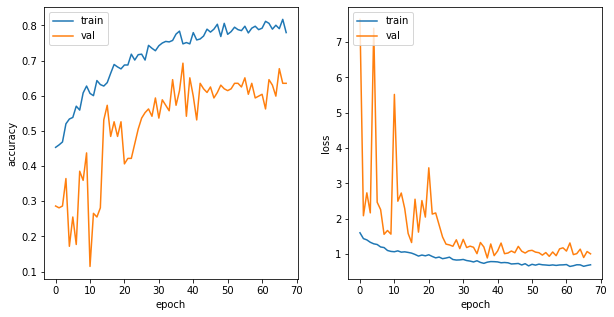

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 196 images belonging to 6 classes.
Accuracy: 0.6275510204081632
Global F2 Score: 0.6275510204081632


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F-Score,Support
BareAreas,0.382022,0.850000,0.527132,40.0
BuiltUp,0.960784,0.890909,0.924528,55.0
Cropland,0.750000,0.545455,0.631579,33.0
Grassland,0.000000,0.000000,0.000000,18.0
Water,0.800000,0.333333,0.470588,24.0
Woodland,0.636364,0.538462,0.583333,26.0


In [ ]:
# confusion matrix as values
conf_mat

,BareAreas,BuiltUp,Cropland,Grassland,Water,Woodland
BareAreas,34,0,1,0,0,5
BuiltUp,4,49,0,0,1,1
Cropland,13,1,18,0,0,1
Grassland,14,1,2,0,0,1
Water,14,0,2,0,8,0
Woodland,10,0,1,0,1,14


In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

,BareAreas,BuiltUp,Cropland,Grassland,Water,Woodland
BareAreas,38.20,0.00,4.17,NaN,0.0,22.73
BuiltUp,4.49,96.08,0.00,NaN,10.0,4.55
Cropland,14.61,1.96,75.00,NaN,0.0,4.55
Grassland,15.73,1.96,8.33,NaN,0.0,4.55
Water,15.73,0.00,8.33,NaN,80.0,0.00
Woodland,11.24,0.00,4.17,NaN,10.0,63.64


In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/zimsat/working/vgg16_zimsat8breg_act_batch64_red1.h5')

# VGG16 MODEL - Training results with 5 classes

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 5.0911 - categorical_accuracy: 0.3626 - auc: 0.6663
Epoch 00001: val_categorical_accuracy improved from -inf to 0.26042, saving model to /content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5
12/12 [==============================] - 7s 356ms/step - loss: 5.0911 - categorical_accuracy: 0.3626 - auc: 0.6663 - val_loss: 43.1227 - val_categorical_accuracy: 0.2604 - val_auc: 0.5697
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 3.7439 - categorical_accuracy: 0.4338 - auc: 0.7356
Epoch 00002: val_categorical_accuracy improved from 0.26042 to 0.30208, saving model to /content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5
12/12 [==============================] - 2s 199ms/step - loss: 3.7439 - categorical_accuracy: 0.4338 - auc: 0.7356 - val_loss: 12.7025 - val_categorical_accuracy: 0.3021 - val_auc: 0.5872
Epoch 3/50
12/12 [==============================] - E

In [ ]:
# re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
12/12 [==============================] - ETA: 0s - loss: 1.2998 - categorical_accuracy: 0.5169 - auc: 0.8117
Epoch 00001: val_categorical_accuracy did not improve from 0.63542
12/12 [==============================] - 4s 205ms/step - loss: 1.2998 - categorical_accuracy: 0.5169 - auc: 0.8117 - val_loss: 1.2975 - val_categorical_accuracy: 0.5104 - val_auc: 0.8313 - lr: 1.0000e-04
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 1.2567 - categorical_accuracy: 0.5174 - auc: 0.8178
Epoch 00002: val_categorical_accuracy did not improve from 0.63542
12/12 [==============================] - 2s 170ms/step - loss: 1.2567 - categorical_accuracy: 0.5174 - auc: 0.8178 - val_loss: 2.4866 - val_categorical_accuracy: 0.2708 - val_auc: 0.6564 - lr: 1.0000e-04
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 1.1028 - categorical_accuracy: 0.5732 - auc: 0.8637
Epoch 00003: val_categorical_accuracy did not improve from 0.63542
12/12 [=====================

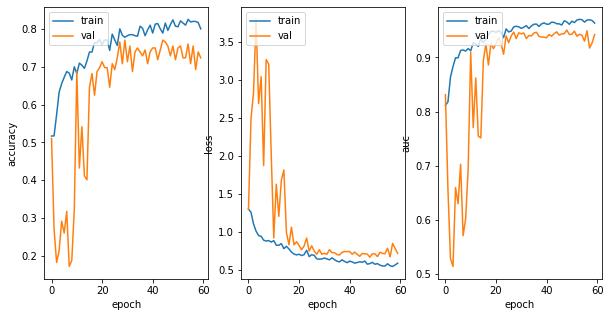

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 196 images belonging to 5 classes.
Accuracy: 0.6887755102040817
Global F2 Score: 0.6887755102040817


,Precision,Recall,F-Score,Support
BuiltUp,0.576087,0.963636,0.721088,55.0
Cropland,0.807692,0.636364,0.711864,33.0
GrassBareAreas,0.968750,0.534483,0.688889,58.0
Water,0.600000,0.625000,0.612245,24.0
Woodland,0.714286,0.576923,0.638298,26.0


In [ ]:
# confusion matrix as values
conf_mat

,BuiltUp,Cropland,GrassBareAreas,Water,Woodland
BuiltUp,53,1,0,1,0
Cropland,7,21,0,2,3
GrassBareAreas,14,4,31,6,3
Water,8,0,1,15,0
Woodland,10,0,0,1,15


In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

,BuiltUp,Cropland,GrassBareAreas,Water,Woodland
BuiltUp,57.61,3.85,0.00,4.0,0.00
Cropland,7.61,80.77,0.00,8.0,14.29
GrassBareAreas,15.22,15.38,96.88,24.0,14.29
Water,8.70,0.00,3.12,60.0,0.00
Woodland,10.87,0.00,0.00,4.0,71.43


In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/zimsat/working/vgg16_zimsat8breg_act_batch64_red1.h5')

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 200

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
76/77 [============================>.] - ETA: 0s - loss: 4.3103 - categorical_accuracy: 0.4002
Epoch 00001: val_categorical_accuracy improved from -inf to 0.51645, saving model to /content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5
77/77 [==============================] - 7s 69ms/step - loss: 4.2830 - categorical_accuracy: 0.4015 - val_loss: 3.3010 - val_categorical_accuracy: 0.5164
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 1.7344 - categorical_accuracy: 0.5008
Epoch 00002: val_categorical_accuracy did not improve from 0.51645
77/77 [==============================] - 4s 54ms/step - loss: 1.7344 - categorical_accuracy: 0.5008 - val_loss: 1.8762 - val_categorical_accuracy: 0.4474
Epoch 3/50
76/77 [============================>.] - ETA: 0s - loss: 1.4694 - categorical_accuracy: 0.5231
Epoch 00003: val_categorical_accuracy did not improve from 0.51645
77/77 [==============================] - 4s 54ms/step - loss: 1.4705 - categ

In [ ]:
# re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/200
77/77 [==============================] - ETA: 0s - loss: 1.4130 - categorical_accuracy: 0.5277
Epoch 00001: val_categorical_accuracy did not improve from 0.59539
77/77 [==============================] - 7s 61ms/step - loss: 1.4130 - categorical_accuracy: 0.5277 - val_loss: 265.0846 - val_categorical_accuracy: 0.2138 - lr: 1.0000e-04
Epoch 2/200
76/77 [============================>.] - ETA: 0s - loss: 1.4570 - categorical_accuracy: 0.5149
Epoch 00002: val_categorical_accuracy did not improve from 0.59539
77/77 [==============================] - 4s 56ms/step - loss: 1.4542 - categorical_accuracy: 0.5155 - val_loss: 7.5577 - val_categorical_accuracy: 0.1184 - lr: 1.0000e-04
Epoch 3/200
77/77 [==============================] - ETA: 0s - loss: 1.3838 - categorical_accuracy: 0.5179
Epoch 00003: val_categorical_accuracy did not improve from 0.59539
77/77 [==============================] - 4s 57ms/step - loss: 1.3838 - categorical_accuracy: 0.5179 - val_loss: 2.3059 - val_categoric

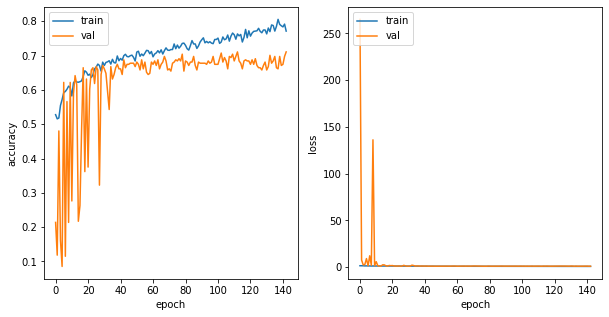

In [ ]:
plot_history(vgg16_history)

In [ ]:
vgg16_model.load_weights('/content/drive/My Drive/Colab Notebooks/zimsat/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 312 images belonging to 6 classes.
Accuracy: 0.6955128205128205
Global F2 Score: 0.6955128205128205


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F-Score,Support
BareAreas,0.645631,0.910959,0.755682,146.0
BuiltUp,0.797101,0.846154,0.820896,65.0
Cropland,0.736842,0.424242,0.538462,33.0
Grassland,0.000000,0.000000,0.000000,18.0
Water,1.000000,0.208333,0.344828,24.0
Woodland,0.769231,0.384615,0.512821,26.0


In [ ]:
# confusion matrix as values
conf_mat

,BareAreas,BuiltUp,Cropland,Grassland,Water,Woodland
BareAreas,133,8,2,0,0,3
BuiltUp,9,55,1,0,0,0
Cropland,18,1,14,0,0,0
Grassland,15,1,2,0,0,0
Water,15,4,0,0,5,0
Woodland,16,0,0,0,0,10


In [ ]:
# confusion matrix as percentage
round(conf_mat/ conf_mat.astype(np.float).sum(axis=0)*100,2)

,BareAreas,BuiltUp,Cropland,Grassland,Water,Woodland
BareAreas,64.56,11.59,10.53,NaN,0.0,23.08
BuiltUp,4.37,79.71,5.26,NaN,0.0,0.00
Cropland,8.74,1.45,73.68,NaN,0.0,0.00
Grassland,7.28,1.45,10.53,NaN,0.0,0.00
Water,7.28,5.80,0.00,NaN,100.0,0.00
Woodland,7.77,0.00,0.00,NaN,0.0,76.92


In [ ]:
# Save the model and the weights
vgg16_model.save('/content/drive/My Drive/Colab Notebooks/zimsat/working/vgg16_zimsat8breg_act_batch16.h5')